Training data shape: (2858, 20)
Loaded model: GradientBoosting
Model expects features: ['temperature', 'humidity', 'pressure', 'windspeed', 'winddirection', 'precipitation', 'hour', 'day', 'month', 'day_of_week']
Feature matrix shape: (2858, 10)
SHAP values shape: (2858, 10)


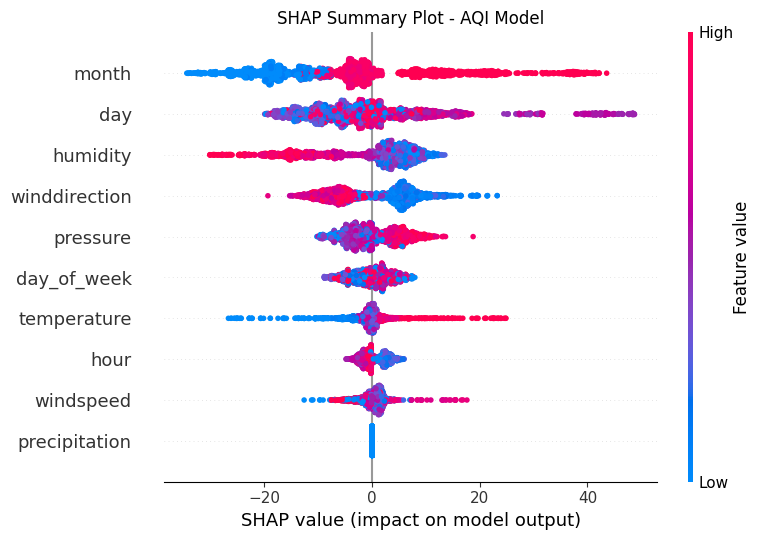

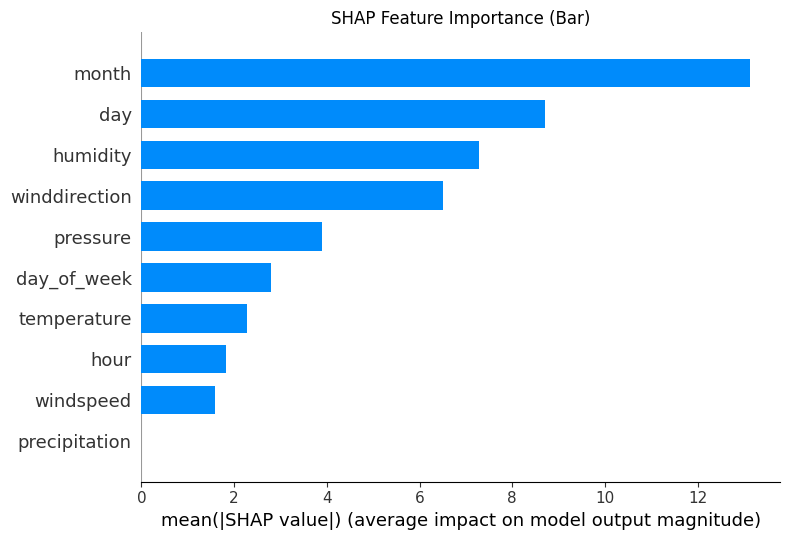


Top Important Features:

         feature  importance
8          month   13.119524
7            day    8.708306
1       humidity    7.287951
4  winddirection    6.495545
2       pressure    3.894932
9    day_of_week    2.799319
0    temperature    2.273423
6           hour    1.832337
3      windspeed    1.590204
5  precipitation    0.000000



Force plot saved as shap_force_plot.html


In [ ]:
# 🌫️ explain_model.py
# ---------------------------------------------------
# SHAP-based Feature Importance for AQI Model
# ---------------------------------------------------

# 1️⃣ Imports
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import plotly.express as px
from pymongo import MongoClient
from dotenv import load_dotenv
import os
import pickle

# ---------------------------------------------------
# 2️⃣ Load MongoDB Connection
# ---------------------------------------------------
load_dotenv()
MONGO_URI = os.getenv("MONGO_URI")

if not MONGO_URI:
    raise Exception("MONGO_URI not found in .env file")

client = MongoClient(MONGO_URI)
db = client["aqi_database"]

data_col = db["training_features"]
model_col = db["model_registry"]

# ---------------------------------------------------
# 3️⃣ Load Training Data
# ---------------------------------------------------
df = pd.DataFrame(list(data_col.find({}, {"_id": 0})))

if df.empty:
    raise Exception("No training data found in MongoDB")

print("Training data shape:", df.shape)

# ---------------------------------------------------
# 4️⃣ Load Best Model
# ---------------------------------------------------
model_entry = model_col.find_one(sort=[("created_at", -1)])

if not model_entry:
    raise Exception("No trained model found in registry")

best_model = pickle.loads(model_entry["model_binary"])

print("Loaded model:", model_entry["model_name"])

# ---------------------------------------------------
# 5️⃣ Align Features EXACTLY With Training
# ---------------------------------------------------

if not hasattr(best_model, "feature_names_in_"):
    raise Exception("Model does not contain feature names. Retrain using DataFrame.")

# Extract exact features used in training
model_features = list(best_model.feature_names_in_)
print("Model expects features:", model_features)

# Ensure all expected features exist in dataset
missing_cols = [col for col in model_features if col not in df.columns]
if missing_cols:
    raise Exception(f"Missing columns in dataset: {missing_cols}")

# Create feature matrix in correct order
X = df[model_features].copy()

print("Feature matrix shape:", X.shape)

# ---------------------------------------------------
# 6️⃣ Initialize SHAP Explainer (Tree Optimized)
# ---------------------------------------------------

explainer = shap.TreeExplainer(best_model)

# Disable strict additivity check (safe for tree models)
shap_values = explainer.shap_values(X, check_additivity=False)

print("SHAP values shape:", np.array(shap_values).shape)

# ---------------------------------------------------
# 7️⃣ SHAP Summary Plot (Beeswarm)
# ---------------------------------------------------
plt.figure()
shap.summary_plot(shap_values, X, max_display=15, show=False)
plt.title("SHAP Summary Plot - AQI Model")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 8️⃣ SHAP Bar Plot (Global Importance)
# ---------------------------------------------------
plt.figure()
shap.summary_plot(shap_values, X, plot_type="bar", max_display=15, show=False)
plt.title("SHAP Feature Importance (Bar)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 9️⃣ Compute Mean Absolute SHAP Importance
# ---------------------------------------------------
feature_importance = pd.DataFrame({
    "feature": model_features,
    "importance": np.abs(shap_values).mean(axis=0)
}).sort_values(by="importance", ascending=False)

print("\nTop Important Features:\n")
print(feature_importance)

# ---------------------------------------------------
# 🔟 Plotly Interactive Importance Chart
# ---------------------------------------------------
fig = px.bar(
    feature_importance,
    x="feature",
    y="importance",
    title="Feature Importance for AQI Prediction (SHAP)",
    labels={
        "importance": "Mean |SHAP Value|",
        "feature": "Feature"
    }
)

fig.show()

# ---------------------------------------------------
# 1️⃣1️⃣ Force Plot for First Observation
# ---------------------------------------------------
shap.initjs()

sample_index = 0

force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[sample_index],
    X.iloc[sample_index]
)

# Save force plot as HTML
shap.save_html("shap_force_plot.html", force_plot)

interaction_values = explainer.shap_interaction_values(X)
np.abs(shap_values).mean(axis=0)


print("\nForce plot saved as shap_force_plot.html")
print("Model features:", best_model.feature_names_in_)
print("SHAP X features:", X.columns.tolist())

